## I-4 Causality and Experiment Design

In [28]:
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
from sklearn.linear_model import LinearRegression
%matplotlib inline

### 4.1 -- 2SLS to estimate the effect of precipitation on #bike rentals
#### 4.1.1 The causal model
We like to know more about what causes a higher or lower **number of rentals** on a
given day. More specifically,<br/> to determine the effect that **weather conditions**
have on the number of bike rentals.

* Using the daily UCI data, run a two stage least squares regression to calculate the effect of adverse weather (weathersit > 1) vs <br/>nice weather (weathersit = 1) on the total number of rentals.
* Since we are given an observed data set, we will use **instrumental variables analysis and 2 stage least squares regression**. In <br/>particular, **temperature** is a potential confounding variable for weather and the number of bike rentals. To overcome this,<br/> **humidity** is used as an instrumental variable.

In [29]:
# Read in the csv of chicago.
day_df = pd.read_csv("../data/bikeshare/day.csv")
rentals = day_df["cnt"]
temperature = day_df["temp"]
humidity = day_df["hum"]
weather = day_df["weathersit"]
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


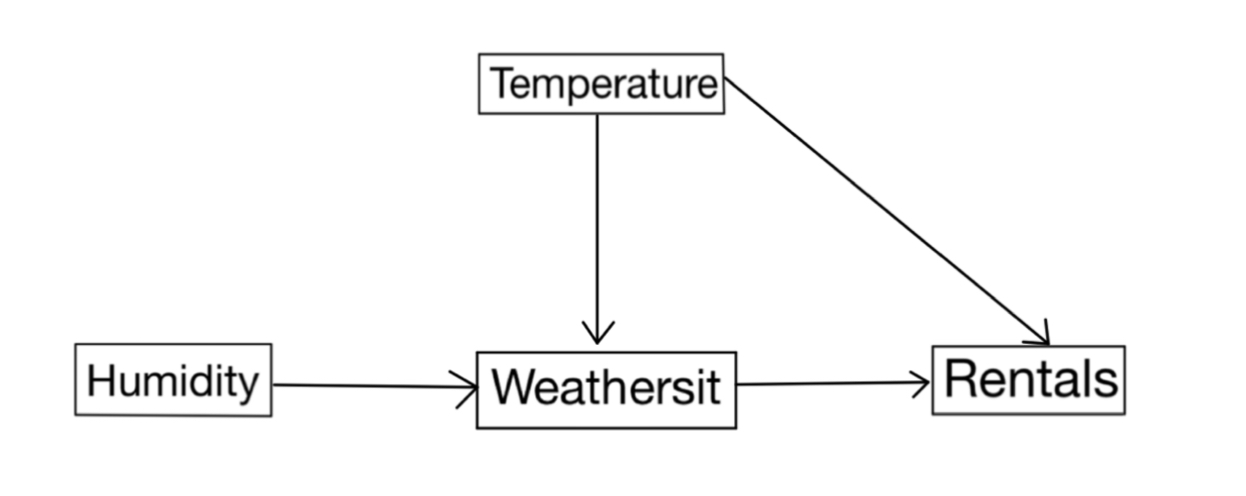

In [30]:
from IPython.display import Image
Image(filename = "causal.jpeg", width = 600, height = 800)

In [31]:
np.corrcoef(rentals, temperature)

array([[1.        , 0.62749401],
       [0.62749401, 1.        ]])

In [32]:
np.corrcoef(rentals, weather)

array([[ 1.        , -0.29739124],
       [-0.29739124,  1.        ]])

In [33]:
np.corrcoef(weather, temperature)

array([[ 1.        , -0.12060224],
       [-0.12060224,  1.        ]])

In [34]:
np.corrcoef(weather, humidity)

array([[1.       , 0.5910446],
       [0.5910446, 1.       ]])

In [35]:
np.corrcoef(temperature, humidity)

array([[1.        , 0.12696294],
       [0.12696294, 1.        ]])

Assumptions for 2SLS: 
1. Rentals is correlated with weathersit and temperature.  
By np.corrcoef's computation, the correlation between rentals and temperature is 0.6274;  
the correlation between rentals and weather is -0.2973.  
  
  
  
2. Weather is correlated with temperature (the part causing problem without using 2SLS).  
By np.corrcoef's computation, the correlation between weather and temperature is -0.1206,  
which is not as strong as expected, this can be a good thing, meaning we probably over concern.


3. Weather is correlated with Humidty.  
By np.corrcoef's computation, the correlation between weather and humidity is 0.5910.   
That's good because our instrumental variable has a pretty strong correlation with weathersit.


4. Humidity is not correlated with tempeture.  
By np.corrcoef's computation, the correlation between Humidity and temperature is 0.12;  
That's good because that means our instrumental variable is not correlated with the   
endogenous variable too much.

#### 4.1.2 Two-Stage Least Square
* For comparision reason, I conduct the method both with/without 2SLS, and see their performances respectiely.

#### -Without 2SLS

In [38]:
ols_features = weather
ols_features_w_const = sm.add_constant(ols_features)
ols_model = sm.OLS(rentals, ols_features_w_const)
ols_results = (ols_model.fit()).params

print("constant_est: ",ols_results[0])
print("alpha_1: ",ols_results[1])

constant_est:  5979.6330472103
alpha_1:  -1057.2870171673824


**Here we have our fitted model without 2SLS:**<br/>
Model:<br/>
$rentals =\hspace{0.4cm} \alpha_{0}\hspace{0.3cm} + \hspace{0.4cm}\alpha_{1}\hspace{0.4cm} weather + \hspace{0.4cm}\epsilon$<br/>
$\hat{rentals} =\hspace{0.4cm} \hat{\alpha_{0}}\hspace{0.3cm} + \hspace{0.4cm}\hat{\alpha_{1}}\hspace{0.4cm} weather$ <br />
$\hspace{1.4cm} = 5979.6 - 1057.3weather$

#### -With 2SLS

In [39]:
## first stage
stage1_features = humidity
stage1_features_w_const = sm.add_constant(stage1_features) # prepend a constant feature for intercept term
stage1_ols = sm.OLS(weather, stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params # predicted coefficients
print("stage1_constant_alpha: ", stage1_ols_results[0])
print("stage1_ols_alpha: ", stage1_ols_results[1])

stage1_constant_alpha:  -0.024428413138057353
stage1_ols_alpha:  2.2611732363382817


**First stage of 2SLS:**<br/>
Model:<br/>
$weather =\hspace{0.5cm} \alpha_{0}\hspace{0.5cm} + \hspace{0.4cm}\alpha_{1}\hspace{0.4cm} humidity + \hspace{0.5cm}\epsilon$<br/>
$\hat{weather} =\hspace{0.5cm} \hat{\alpha_{0}}\hspace{0.5cm} + \hspace{0.4cm}\hat{\alpha_{1}}\hspace{0.4cm} humidity$ <br />
$\hspace{1.6cm} = -0.0244 + 2.2611humidity$

In [41]:
weather_hat = np.dot(stage1_features_w_const, np.array([stage1_ols_results]).T)

In [42]:
# Second Stage
stage2_features = weather_hat
stage2_features_w_const = sm.add_constant(stage2_features)  # prepend a constant feature for intercept term
stage2_model = sm.OLS(rentals, stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params
alpha_2SLS = stage2ols_results[1]
print("stage2_constant_alpha: ", stage2ols_results[0])
print("stage2_ols_alpha: ", alpha_2SLS)

stage2_constant_alpha:  5349.195695177064
stage2_ols_alpha:  -605.4735815435627


**Second stage of 2SLS:**<br/>
Model:<br/>
$rentals =\hspace{0.5cm} \alpha_{0}\hspace{0.5cm} + \hspace{0.4cm}\alpha_{1}\hspace{0.4cm} \hat{weather} + \hspace{0.5cm}\epsilon$<br/>
$rentals =\hspace{0.5cm} \hat{\alpha_{0}}\hspace{0.6cm}  + \hspace{0.4cm}\hat{\alpha_{1}}\hspace{0.4cm} \hat{weather}$ <br />
$\hspace{1.6cm} = 5349.19 - 605.47\hat{weather}$

**Interpretation:** Similar to the previous part, now we apply 2SLS when obtaining the treatment effect of weathersit onto<br /> casual rentals and registered rentals. That is, conduct 2SLS procedures as above seperately for casual and subscribers group.

* For casual rentals, the treatment effect is -164.18, meaning a unit increase in weathersit results in 164 decrease in number of casual rentals.

* For registered rentals, the treatment effect is -441.29, meaning a unit increase in weathersit results in 441 decrease in number of registered rentals.

* As sanity check, the treatment effect of casual and registered rentals add up to -605, which is the treatment effect of weathersit onto the total rentals.